In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

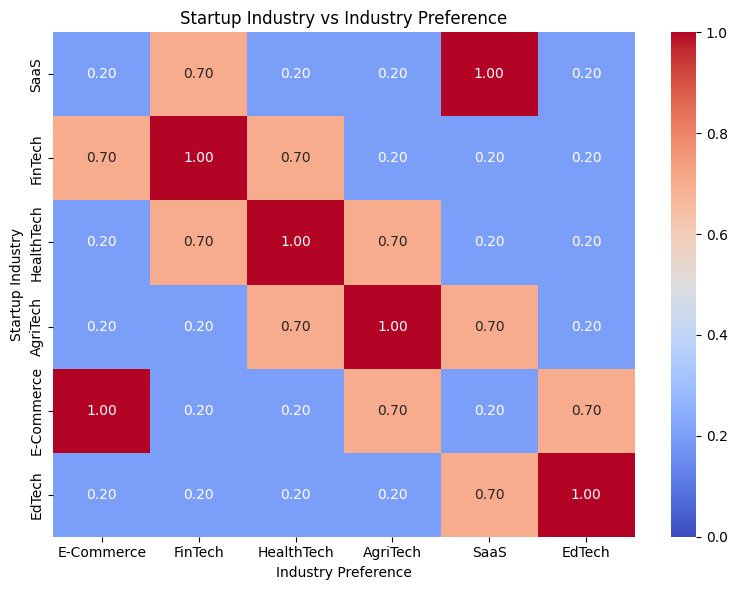

In [2]:
startup_industry = ['SaaS', 'FinTech', 'HealthTech', 'AgriTech', 'E-Commerce', 'EdTech']
industry_preference = ['E-Commerce', 'FinTech', 'HealthTech', 'AgriTech', 'SaaS', 'EdTech']

startup_industry_scores = {}  
for i, si in enumerate(startup_industry):
    for j, ip in enumerate(industry_preference):
        if si == ip:
            score = 1.0
        elif abs(i - j) == 1:
            score = 0.7
        else:
            score = 0.2
        startup_industry_scores[(si, ip)] = score

matrix = np.zeros((len(startup_industry), len(industry_preference)))
for i, si in enumerate(startup_industry):
    for j, ip in enumerate(industry_preference):
        matrix[i, j] = startup_industry_scores.get((si, ip), 0.0)

plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=industry_preference, yticklabels=startup_industry, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Startup Industry vs Industry Preference')
plt.xlabel('Industry Preference')
plt.ylabel('Startup Industry')
plt.tight_layout()
plt.show()

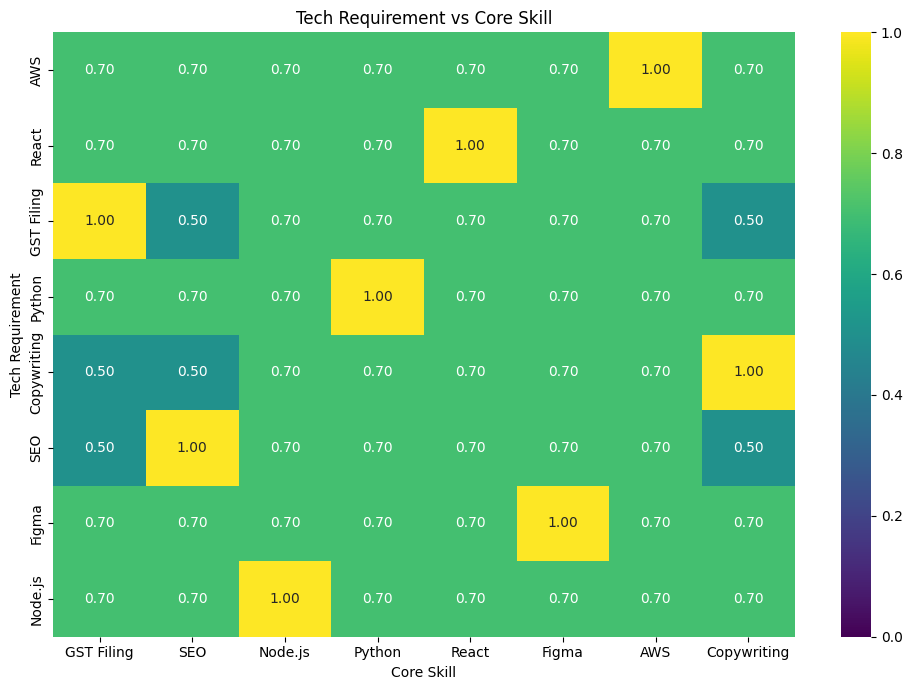

In [3]:
tech_requirement = ['AWS', 'React', 'GST Filing', 'Python', 'Copywriting', 'SEO', 'Figma', 'Node.js']
core_skill      = ['GST Filing', 'SEO', 'Node.js', 'Python', 'React', 'Figma', 'AWS', 'Copywriting']

tech_skill_scores = {}  # Recopy dictionary code from Model notebook if needed
for t1 in tech_requirement:
    for t2 in core_skill:
        if t1 == t2:
            score = 1.0
        elif {t1, t2} & {'Python', 'Node.js', 'React', 'Figma', 'AWS'} and t1 != t2:
            score = 0.7
        elif {t1, t2} & {'Copywriting', 'SEO'} and t1 != t2:
            score = 0.5
        elif 'GST' in t1 or 'GST' in t2:
            score = 0.3
        else:
            score = 0.1
        tech_skill_scores[(t1, t2)] = score

matrix = np.zeros((len(tech_requirement), len(core_skill)))
for i, t1 in enumerate(tech_requirement):
    for j, t2 in enumerate(core_skill):
        matrix[i, j] = tech_skill_scores.get((t1, t2), 0.0)

plt.figure(figsize=(10,7))
sns.heatmap(matrix, annot=True, fmt=".2f", xticklabels=core_skill, yticklabels=tech_requirement, cmap='viridis', vmin=0, vmax=1)
plt.title('Tech Requirement vs Core Skill')
plt.xlabel('Core Skill')
plt.ylabel('Tech Requirement')
plt.tight_layout()
plt.show()

In [17]:
def get_startup_industry_score(si, pref):
    return startup_industry_scores.get((si, pref), 0.0)

def get_tech_skill_score(t1, t2):
    return tech_skill_scores.get((t1, t2), 0.0)

def get_project_need_score(pn, ppt):
    return project_need_scores.get((pn, ppt), 0.0)

def get_deadline_availability_score(req, avail):
    try:
        req = float(req)
        avail = float(avail)
    except:
        return 0.0
    if req == 0:
        return 0.0
    if avail == req:
        return 1.0
    elif avail > req:
        overstay_ratio = (avail - req) / req
        return max(0.5, 1 / (1 + overstay_ratio))
    else:
        return avail / req

# Weights of each pairings
WEIGHTS = {
    'industry': 0.25,
    'project_need': 0.25,
    'tech_skill': 0.30,
    'deadline_availability': 0.20,
}

def calculate_match_score(userA, userB):
    ind_score = get_startup_industry_score(userA.get('startup_industry',''), userB.get('industry_preference',''))
    proj_score = get_project_need_score(userA.get('project_need',''), userB.get('preferred_project_type',''))
    tech_score = get_tech_skill_score(userA.get('tech_requirement',''), userB.get('core_skill',''))
    deadline_score = get_deadline_availability_score(userA.get('project_deadline',0), userB.get('availability',0))
    total = (
        WEIGHTS['industry'] * ind_score +
        WEIGHTS['project_need'] * proj_score +
        WEIGHTS['tech_skill'] * tech_score +
        WEIGHTS['deadline_availability'] * deadline_score
    )
    return round(total, 4)

def find_matches_for_user(user_id, user_type, founders_df, providers_df, mentors_df, top_k=5):
    user_type = user_type.lower()
    if user_type == 'founder':
        user_row = founders_df.loc[user_id]
        match_dict = {
            'mentors': mentors_df,
            'service_providers': providers_df
        }
    elif user_type == 'provider':
        user_row = providers_df.loc[user_id]
        match_dict = {
            'mentors': mentors_df,
            'founders': founders_df
        }
    elif user_type == 'mentor':
        user_row = mentors_df.loc[user_id]
        match_dict = {
            'founders': founders_df,
            'service_providers': providers_df
        }
    else:
        raise ValueError(f"Invalid user_type '{user_type}'. Must be one of 'founder', 'provider', 'mentor'.")

    results = {}
    for target_type, df in match_dict.items():
        matches = []
        for idx, match_row in df.iterrows():
            score = calculate_match_score(user_row, match_row)
            matches.append((idx, score))
        matches_sorted = sorted(matches, key=lambda x: x[1], reverse=True)[:top_k]
        results[target_type] = matches_sorted
    return results

def plot_top_k_matches_bar(user_id, user_type, founders_df, providers_df, mentors_df, top_k=5):
    matches = find_matches_for_user(user_id, user_type, founders_df, providers_df, mentors_df, top_k)
    for group, results in matches.items():
        user_ids = [uid for uid, score in results]
        scores = [score for uid, score in results]
        plt.figure(figsize=(7, 3))
        sns.barplot(x=scores, y=user_ids, orient='h')
        plt.title(f'Top {top_k} {group.title()} for {user_id} ({user_type.title()})')
        plt.xlabel('Match Score')
        plt.ylabel(f'{group.title()} User ID')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

In [18]:
data = pd.read_csv('Cleaned_User_Matching_Dataset.csv')
founders_df = data[data['user_type'] == 'Founder'].set_index('user_id')
providers_df = data[data['user_type'] == 'Service Provider'].set_index('user_id')
mentors_df = data[data['user_type'] == 'Mentor'].set_index('user_id')

In [19]:
user_id = data.loc[50]['user_id']
user_type = data.loc[50]['user_type']

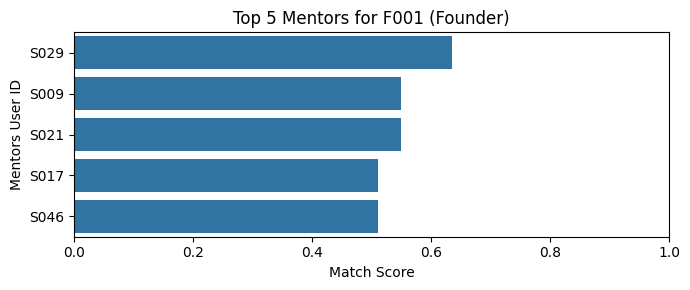

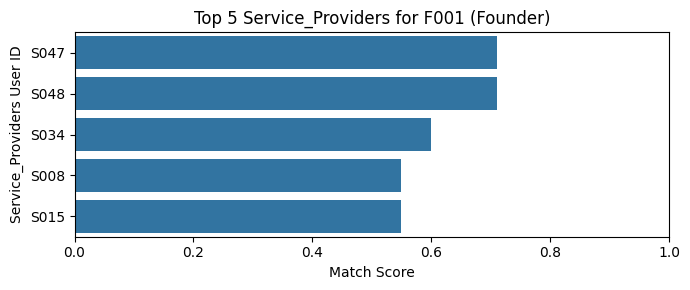

In [20]:
plot_top_k_matches_bar('F001', 'founder', founders_df, providers_df, mentors_df, top_k=5)